# Causal Inference in Internal space with Angle space responses

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from custom_causal_inference import CustomCausalInference
import utils
import plots
import forward_models_causal_inference
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

## Setup

In [2]:
num_sim = 10000 # number of samples to simulate causal inference on
D = 250  # grid dimension 
angle_gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='./uniform_model_base_inv_kappa_free.pkl'

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

## Select the means of cues used for causal inference and the "ground-truth" corresponding responses 

Get the $s_n, t, r_n(s_n, t)$ values of interest such that means are uniform in internal space

Indices in grid of selected stimuli: [ 62  89 107 113 122]
Indices in grid of selected stimuli after wrap test: [ 62  89 107 113 122]


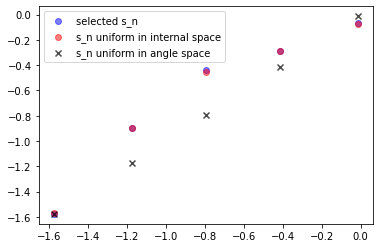

In [ ]:
num_means = 5
grid_sz = num_means**2
# Select indices from quadrant [-np.pi/2, 0)
indices = 250 // 4 + utils.select_evenly_spaced_integers(num=num_means,
                                                        start=0,
                                                        end=250 // 4)
stimuli = np.linspace(-np.pi, np.pi, D)
selected_internal_stimuli = stimuli[indices] # Uniform stimuli in internal space due to evenly spaced integer indices
# Convert to angles because data is in angle space
selected_stimuli = unif_map.unif_space_to_angle_space(selected_internal_stimuli)
# Bin the angles to the 250 discrete angle values in our dataset
grid_indices_selected_stimuli = utils.select_closest_values(
    array=stimuli, # Uniformly spaced angles in [-np.pi, np.pi]
    selected_values=selected_stimuli,
    distance_function=utils.circular_dist)
print(f'Indices in grid of selected stimuli: {grid_indices_selected_stimuli}')
# Handle the wrap
if (grid_indices_selected_stimuli[0] == 0) and (grid_indices_selected_stimuli[-1] == 0):
    grid_indices_selected_stimuli[-1] = D - 1
grid_indices_selected_stimuli = np.sort(grid_indices_selected_stimuli)
grid_indices_selected_stimuli = np.unique(grid_indices_selected_stimuli)
print(f'Indices in grid of selected stimuli after wrap test: {grid_indices_selected_stimuli}')
plt.scatter(selected_internal_stimuli, stimuli[grid_indices_selected_stimuli],
                        label='selected s_n', alpha=.5, c='b')
plt.scatter(selected_internal_stimuli, selected_stimuli,
            label='s_n uniform in internal space', alpha=.5, c='r')
plt.scatter(selected_internal_stimuli, selected_internal_stimuli,
            alpha=.7, c='k', marker='x', label='s_n uniform in angle space')
plt.legend()
plt.show()

In [7]:
t_index = 2 # regressor index (0: r_{n-1}, 1: s_{n-1}, 2: uncued, 3: match)
r_n = causal_inference_estimator.gam_data['full_pdf_mat'][grid_indices_selected_stimuli, :, t_index]
r_n = r_n[:, grid_indices_selected_stimuli]
t, s_n = np.meshgrid(stimuli[grid_indices_selected_stimuli],
                        stimuli[grid_indices_selected_stimuli],
                        indexing='ij')
t.shape, s_n.shape, r_n.shape

((5, 5), (5, 5), (5, 5))

## Causal inference

### Convert means to internal space

In [8]:
s_n, t, r_n = s_n.flatten(), t.flatten(), r_n.flatten()
us_n = unif_map.angle_space_to_unif_space(s_n)
ut = unif_map.angle_space_to_unif_space(t)
print(f'Performing causal inference for ut, u_s_n of shape {ut.shape, us_n.shape}')

Performing causal inference for ut, u_s_n of shape ((25,), (25,))


### Select concentrations based on fits

In [45]:
with open(f'./learned_data/task_metadata_{grid_sz}.pkl', 'rb') as f:
    tasks_metadata = pickle.load(f)
num_tasks = len(tasks_metadata)
errors_dicts = {}
err_for_idx = {}
optimal_kappa1s = np.ones((grid_sz, 20, 50)) * 10
optimal_kappa2s = np.ones((grid_sz, 20, 50)) * 10
saved_errors = np.zeros_like(optimal_kappa1s)
min_num_saved_kappas = 50
for task_idx in range(num_tasks):
    try:
        with open(f'./learned_data/optimal_kappa_errors/errors_dict_{task_idx}_{grid_sz}.pkl', 'rb') as f:
            errors_dicts[task_idx] = pickle.load(f)
            mean_idx = int(tasks_metadata[task_idx]['mean_indices'][0])
            min_error_across_pc = min([errors_dicts[task_idx][p_c]['errors'].min() for p_c in errors_dicts[task_idx].keys()])
            if (mean_idx not in err_for_idx) or (err_for_idx[mean_idx] > min_error_across_pc):
                err_for_idx[mean_idx] = min_error_across_pc
                for p_c_index, p_c in enumerate(errors_dicts[task_idx].keys()):
                    min_num_saved_kappas = min(min_num_saved_kappas, len(errors_dicts[task_idx][p_c]['optimal_kappa1']))
                    assert len(errors_dicts[task_idx][p_c]['optimal_kappa1']) == len(errors_dicts[task_idx][p_c]['optimal_kappa2'])
                    optimal_kappa1s[mean_idx, p_c_index, :len(errors_dicts[task_idx][p_c]['optimal_kappa1'])] = errors_dicts[task_idx][p_c]['optimal_kappa1']
                    optimal_kappa2s[mean_idx, p_c_index, :len(errors_dicts[task_idx][p_c]['optimal_kappa2'])] = errors_dicts[task_idx][p_c]['optimal_kappa2']
                    saved_errors[mean_idx, p_c_index, :len(errors_dicts[task_idx][p_c]['optimal_kappa2'])] = errors_dicts[task_idx][p_c]['errors']
    except:
        print(f'Error for task {task_idx}')
min_num_saved_kappas


2

### Simulate the inference by sampling the 2 internal estimates for each pair of means (and associated concentrations)

In [17]:
results = {
    'responses': [], 
    'posterior_p_common': [],
    'mean_t_est': [], 
    'mean_sn_est': [],
    'p_commons': errors_dicts[0].keys()
}
results['num_sim'] = 10000
results['ut'] = ut
results['us_n'] = us_n

In [20]:
p_commons = results['p_commons']

In [ ]:
for p_c_index, p_common in tqdm(enumerate(p_commons)):
    responses, posterior_p_common, mean_t_est, mean_sn_est = causal_inference_estimator.forward_from_means(
        mu_t=ut, mu_s_n=us_n, kappa1=optimal_kappa1s[:, p_c_index, :5], kappa2=optimal_kappa2s[:, p_c_index, :5], 
        p_common=p_common, num_sim=10000)
    results['responses'].append(responses)
    results['posterior_p_common'].append(posterior_p_common)
    results['mean_t_est'].append(mean_t_est)
    results['mean_sn_est'].append(mean_sn_est)

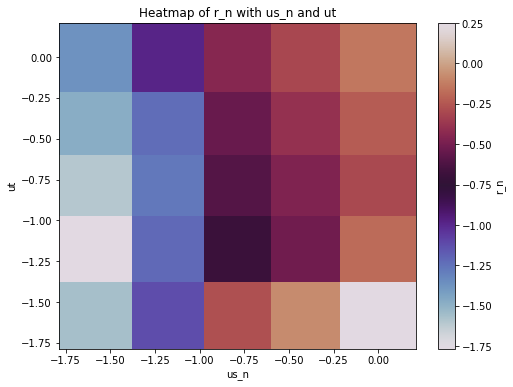

<Figure size 432x288 with 0 Axes>

In [33]:
plots.heatmap_f_s_n_t(f_s_n_t=r_n.reshape((num_means, num_means)), 
                      s_n=us_n.reshape((num_means, num_means)), t=ut.reshape((num_means, num_means)), 
                      f_name='r_n', xlabel='us_n', ylabel='ut')

0it [00:00, ?it/s]

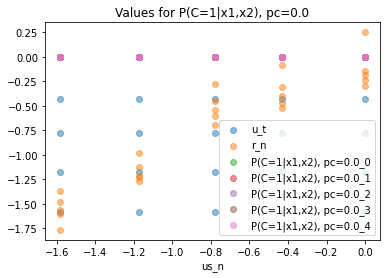

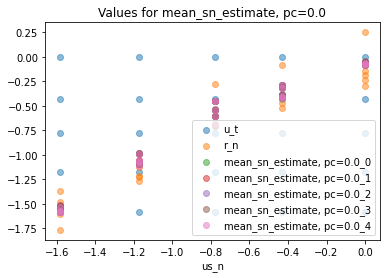

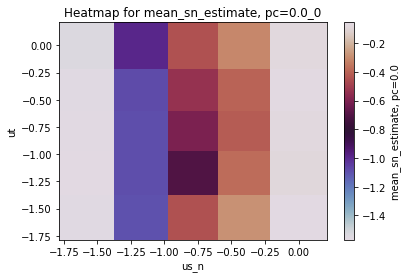

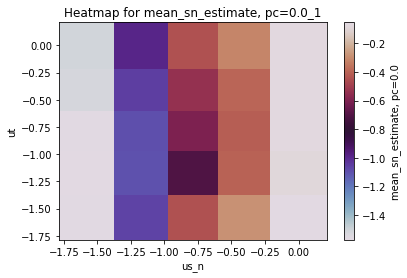

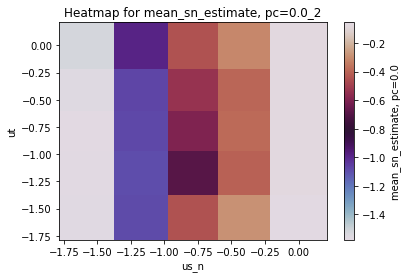

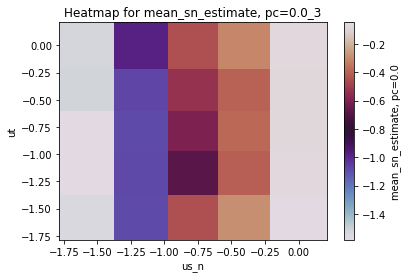

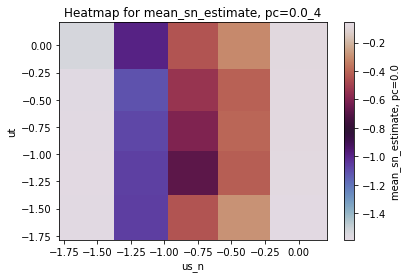

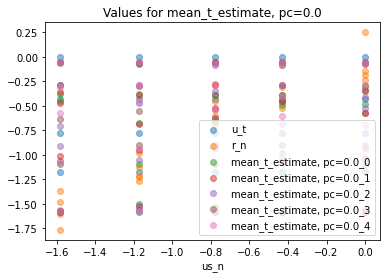

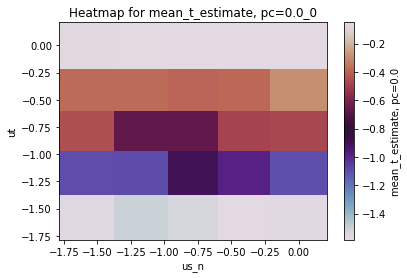

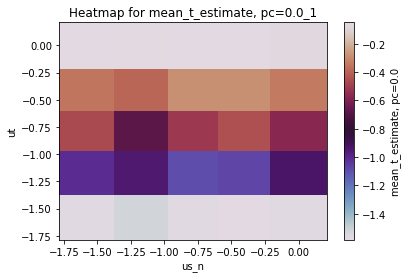

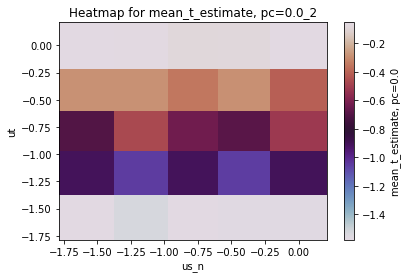

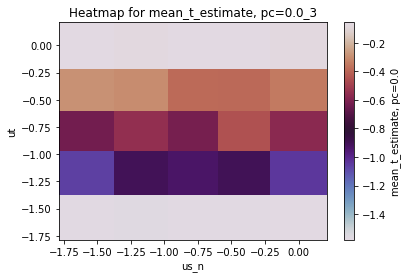

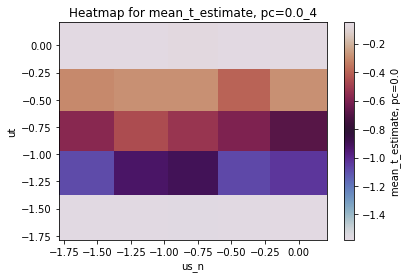

1it [00:02,  2.64s/it]

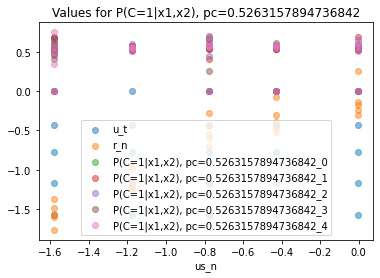

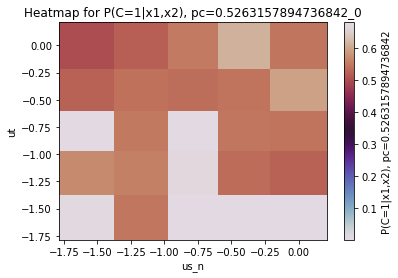

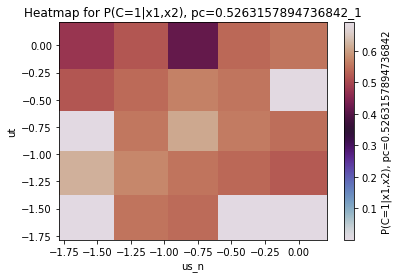

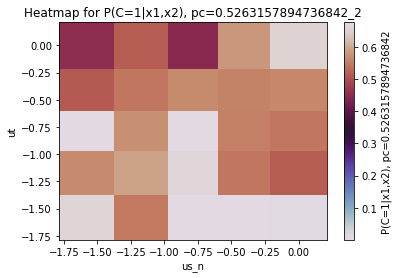

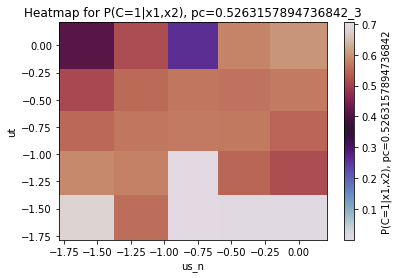

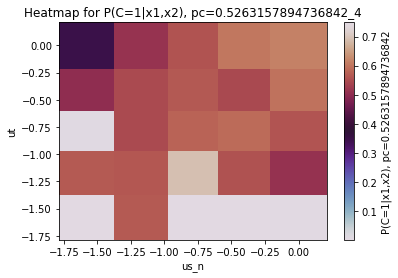

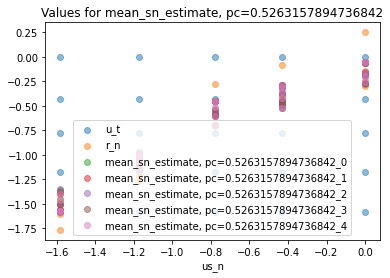

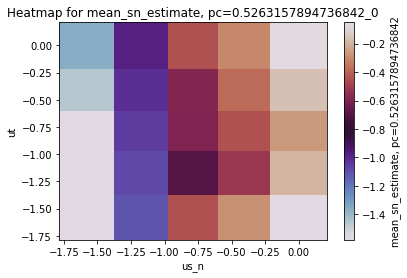

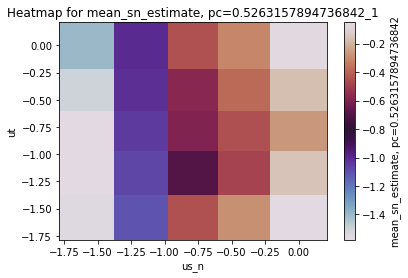

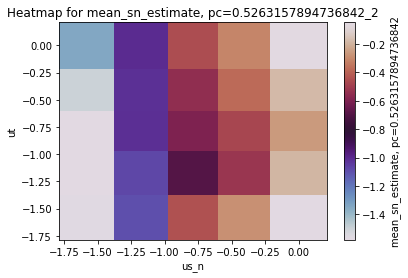

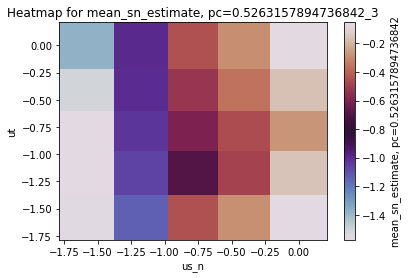

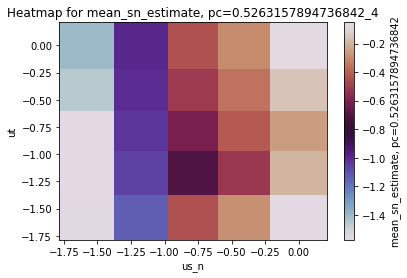

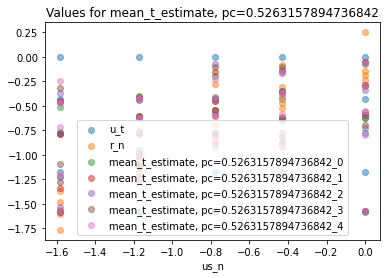

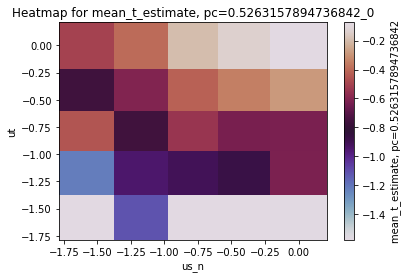

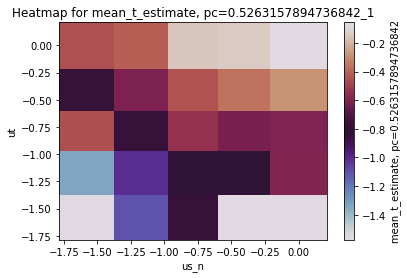

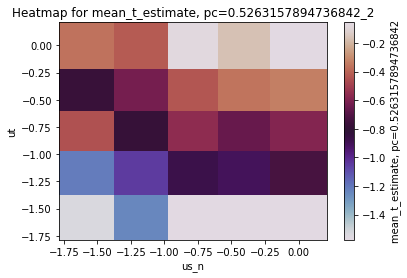

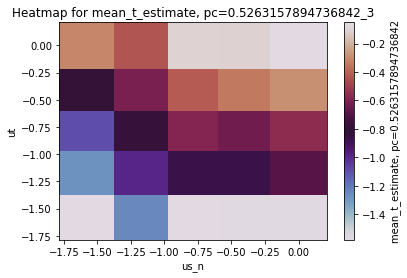

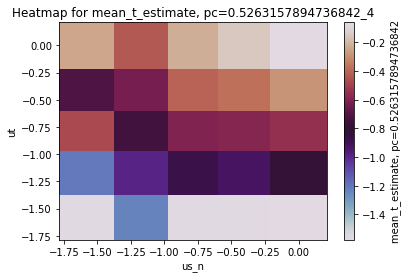

20it [00:06,  3.09it/s]


<Figure size 432x288 with 0 Axes>

In [47]:
fwd_errors = np.zeros_like(saved_errors)
for i, p_c in tqdm(enumerate(p_commons)):
    for grid_idx in range(grid_sz):
        fwd_errors[grid_idx, i, :5] = utils.circular_dist(r_n[grid_idx, np.newaxis], results['mean_sn_est'][i][grid_idx])
        assert (np.allclose(fwd_errors[grid_idx, i, :2], saved_errors[grid_idx, i, :2], atol=np.deg2rad(4))),f'{fwd_errors[grid_idx, i, :5], saved_errors[grid_idx, i, :5]}'
    if i % 10 == 0:
        plot_heatmap = (p_c < 1) and (p_c > 0)
        plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=num_means, 
                        estimate=results['posterior_p_common'][i].mean(axis=0),
                        est_label=f'P(C=1|x1,x2), pc={p_c}', 
                        plot_heatmap=plot_heatmap)
        plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=num_means, 
                        estimate=results['mean_sn_est'][i],
                        est_label=f'mean_sn_estimate, pc={p_c}', 
                        plot_heatmap=True)
        plots.plot_estimate(us_n=us_n, ut=ut, r_n=r_n, mu_x_dim=num_means, 
                        estimate=results['mean_t_est'][i],
                        est_label=f'mean_t_estimate, pc={p_c}', 
                        plot_heatmap=True)